In [174]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import savemat
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy import stats
import seaborn as sns
import os
import glob
from scipy.interpolate import interp2d
from scipy import linalg                  # for linear regression
from sklearn.feature_selection import RFE # for recursive feature selection
from sklearn.linear_model import LinearRegression # linear regression model


df = pd.read_csv('production_aggregate_alt.csv')

In [175]:
def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

In [176]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ln_permeability,73.0,4.463226e+00,2.392018e-01,3.985481e+00,4.307648e+00,4.491543e+00,4.588901e+00,5.081659e+00
"Porosity, fraction",73.0,1.279575e-01,1.151119e-02,1.032663e-01,1.197919e-01,1.288845e-01,1.354811e-01,1.624979e-01
"Acoustic Impedance, kg*s/m^2",73.0,7.322142e+06,9.136130e+04,7.071021e+06,7.283738e+06,7.333472e+06,7.379185e+06,7.509252e+06
"Density, g/cm3",73.0,2.049334e+00,1.483398e-01,1.760142e+00,1.925764e+00,2.077762e+00,2.172085e+00,2.333702e+00
"Compressible velocity, m/s",73.0,3.701996e+03,2.730525e+02,3.226051e+03,3.442823e+03,3.688454e+03,3.924950e+03,4.378612e+03
"Youngs modulus, GPa",73.0,2.722815e+01,2.124119e+00,2.373954e+01,2.535228e+01,2.685275e+01,2.877980e+01,3.162612e+01
"Shear velocity, m/s",73.0,1.675144e+03,2.470054e+01,1.627507e+03,1.655951e+03,1.672785e+03,1.696731e+03,1.730082e+03
"Shear modulus, GPa",73.0,5.757556e+00,4.446032e-01,4.952945e+00,5.382009e+00,5.729173e+00,6.151340e+00,6.725021e+00
varAcousticImpedance,73.0,8.839144e+10,2.383182e+10,4.274172e+10,7.285757e+10,8.558903e+10,1.050000e+11,1.660000e+11
varPorosity,73.0,1.234249e-03,3.788919e-04,6.059450e-04,9.575540e-04,1.137889e-03,1.497762e-03,2.117512e-03


In [177]:
del df['percentile 84']
del df['percentile 50']
del df['percentile 16']

features = 13 # total, besides prod oil, after drops

<IPython.core.display.Javascript object>


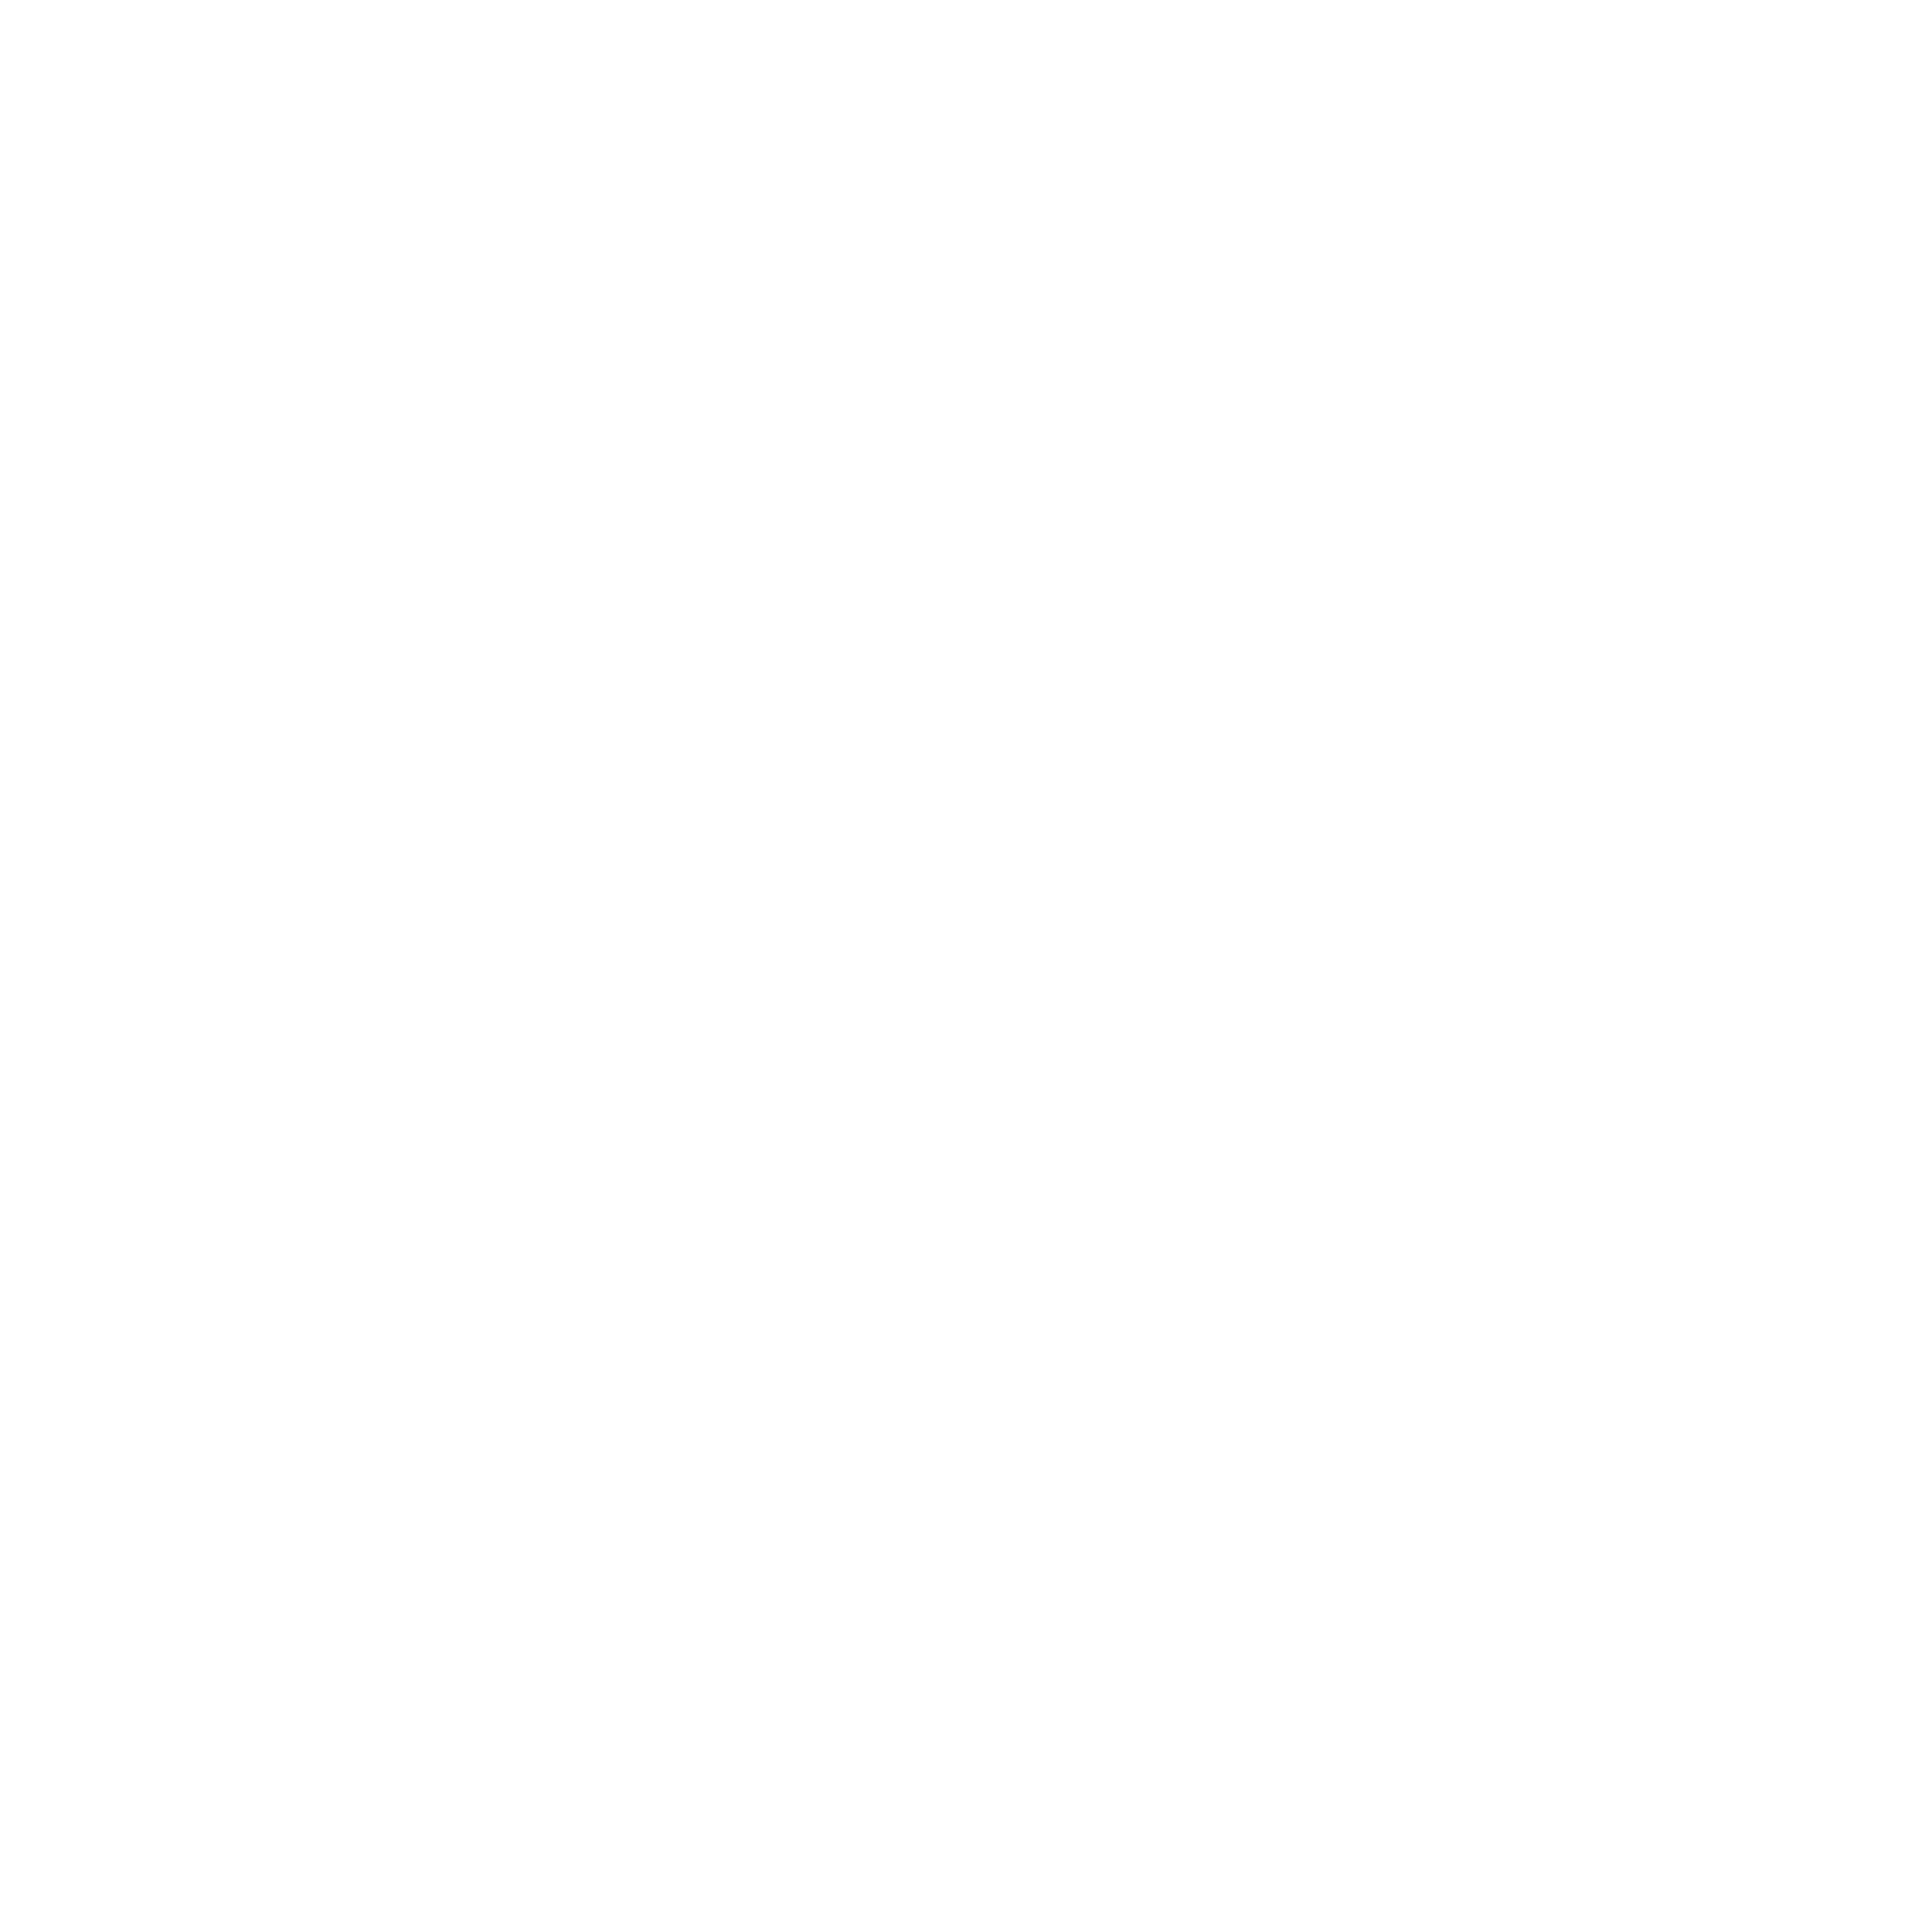

<IPython.core.display.Javascript object>


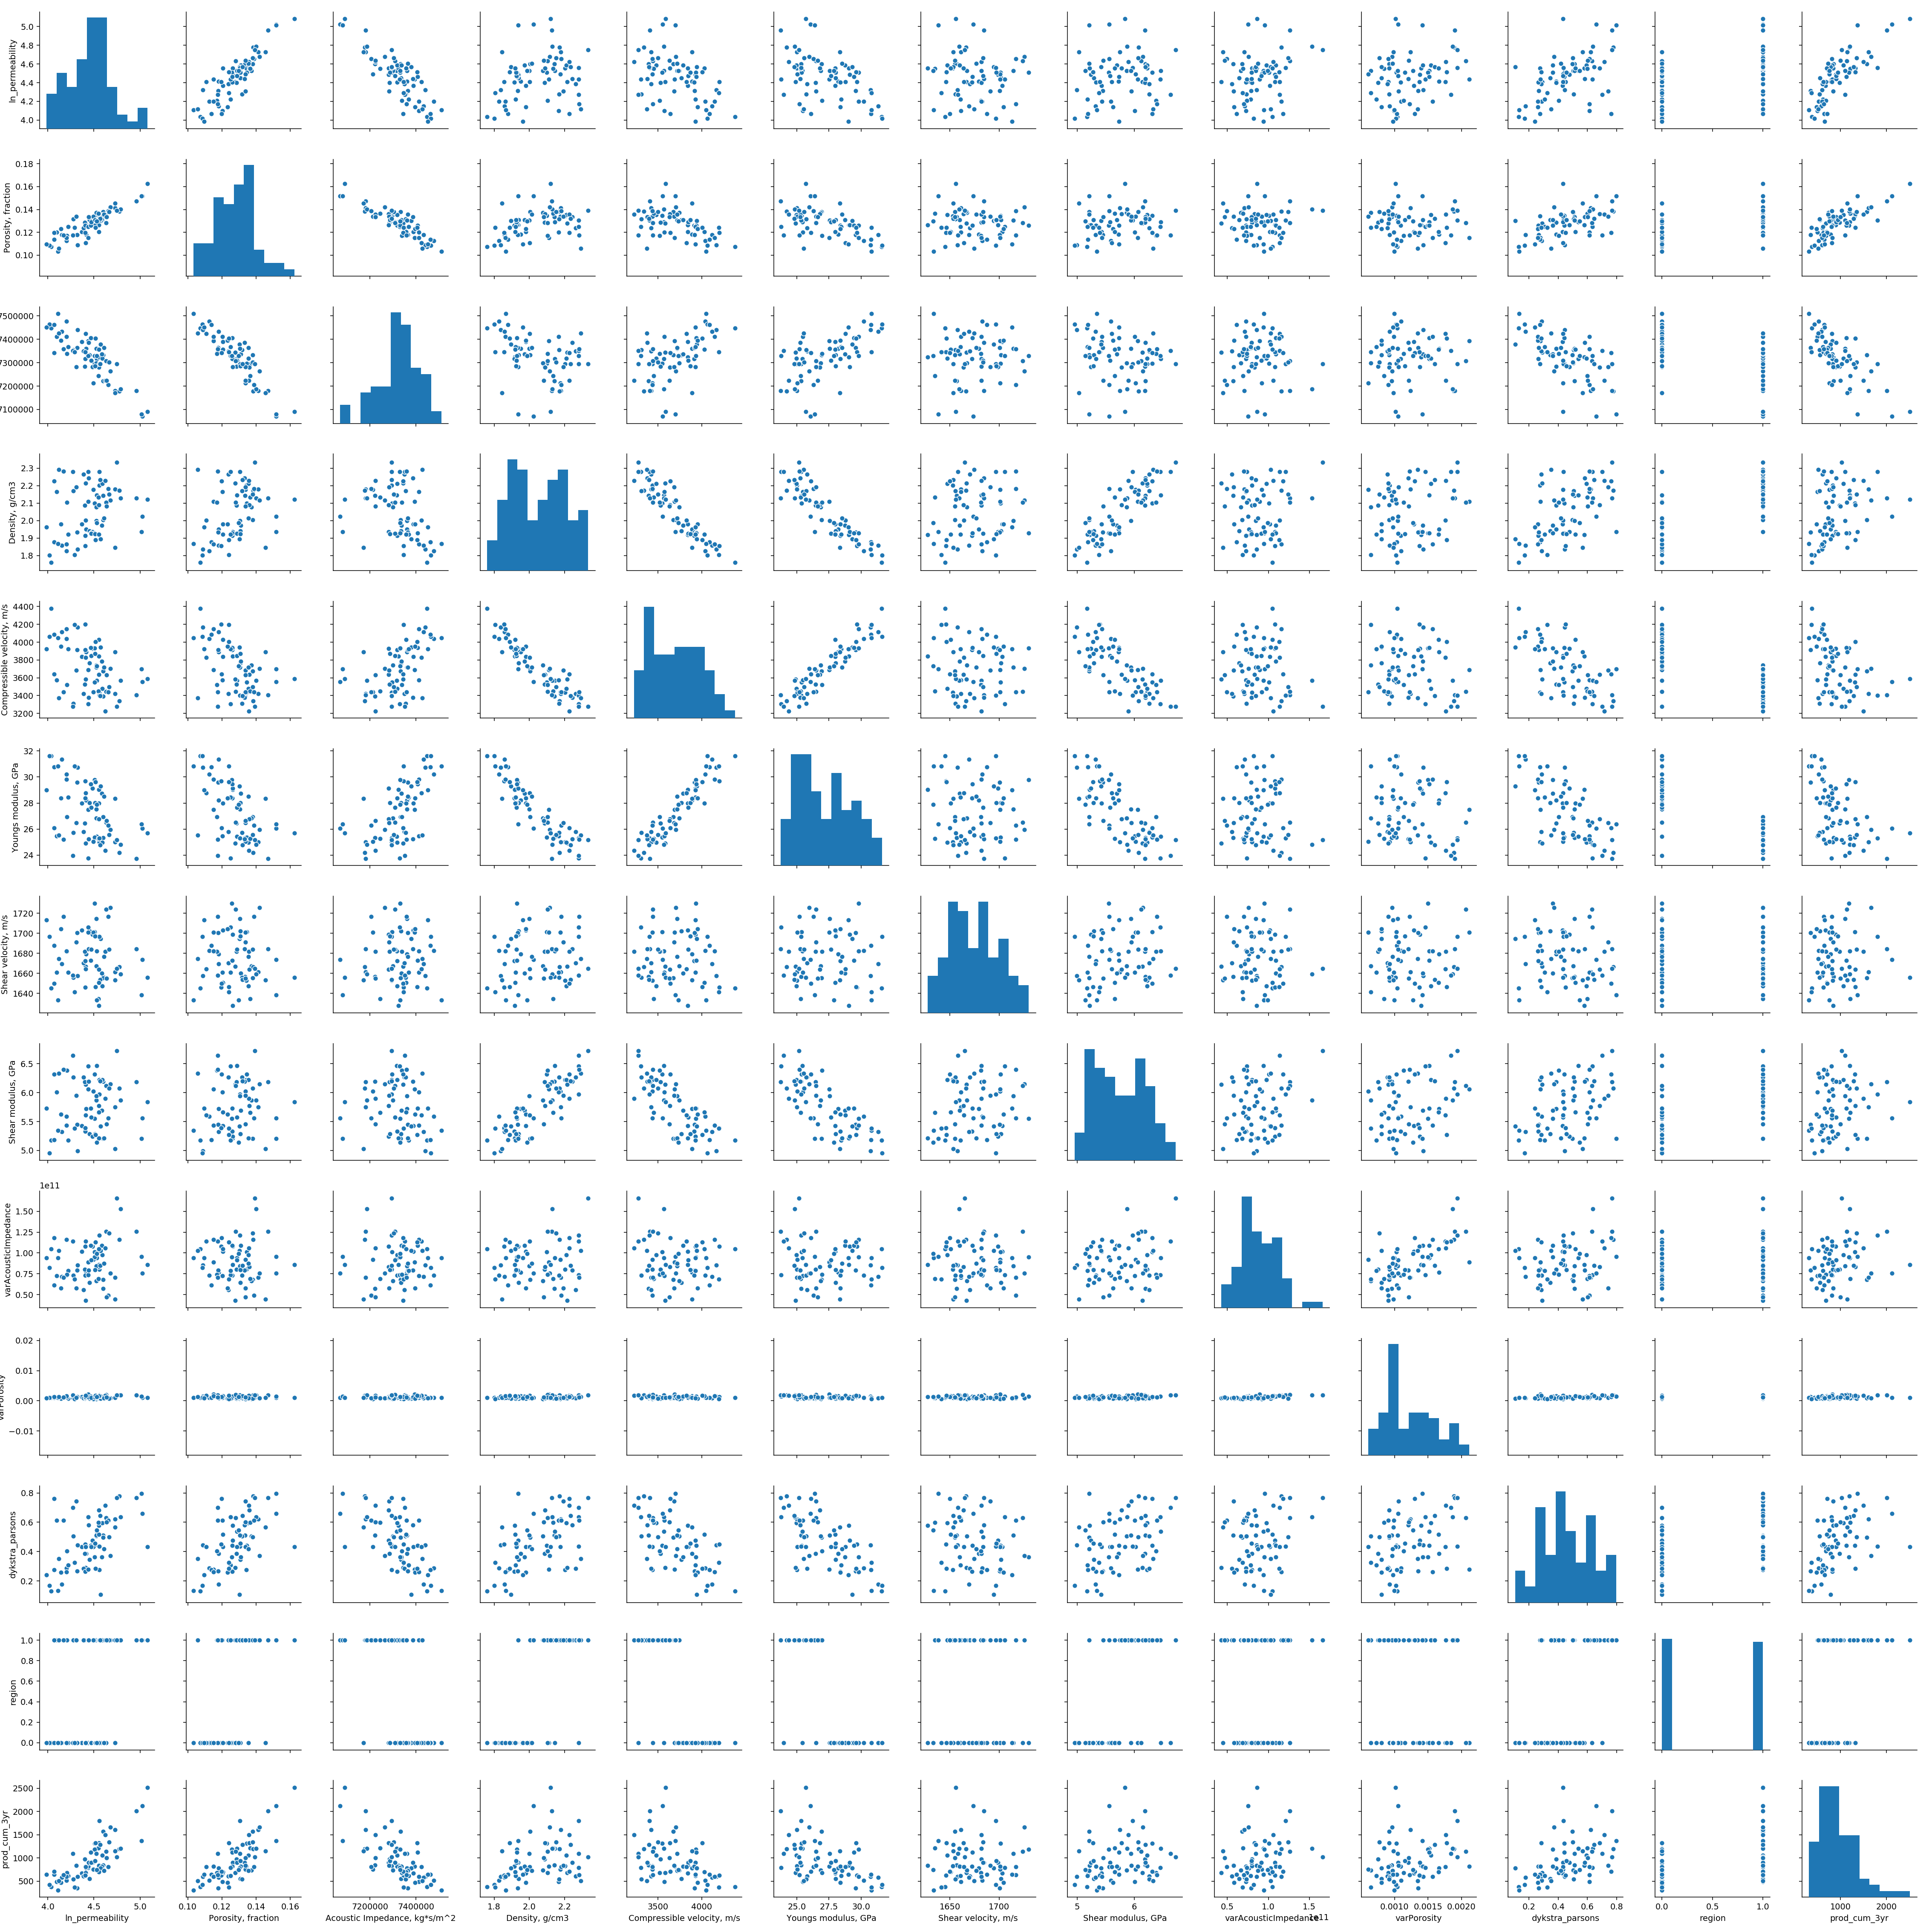

In [178]:
fig = plt.figure(figsize = [15,15])
sns.pairplot(df)

In [179]:
covariance = df.iloc[:,1:features+1].cov().iloc[features-1,0:features-1]
print(covariance)

ln_permeability                 8.118958e+01
Porosity, fraction              3.749676e+00
Acoustic Impedance, kg*s/m^2   -2.806236e+07
Density, g/cm3                  2.004929e+01
Compressible velocity, m/s     -5.046274e+04
Youngs modulus, GPa            -4.545272e+02
Shear velocity, m/s             1.432264e+02
Shear modulus, GPa              3.780313e+01
varAcousticImpedance            2.220835e+12
varPorosity                     4.283503e-02
dykstra_parsons                 3.540685e+01
region                          9.158921e+01
Name: prod_cum_3yr, dtype: float64


In [180]:
correlation = df.iloc[:,1:features+1].corr().iloc[features-1,0:features-1]
print(correlation)

ln_permeability                 0.790040
Porosity, fraction              0.758205
Acoustic Impedance, kg*s/m^2   -0.714949
Density, g/cm3                  0.314597
Compressible velocity, m/s     -0.430168
Youngs modulus, GPa            -0.498075
Shear velocity, m/s             0.013497
Shear modulus, GPa              0.197910
varAcousticImpedance            0.216906
varPorosity                     0.263146
dykstra_parsons                 0.473478
region                          0.423480
Name: prod_cum_3yr, dtype: float64


In [181]:
rank_correlation, rank_correlation_pval = stats.spearmanr(df.iloc[:,1:features+1])

In [182]:
rank_correlation = rank_correlation[:,features-1][:features-1]
rank_correlation_pval = rank_correlation_pval[:,features-1][:features-1]

In [183]:
rank_correlation_pval

array([3.98610370e-17, 1.54737914e-13, 4.08421719e-13, 2.91207883e-03,
       4.90335031e-05, 3.38424313e-06, 9.53725283e-01, 5.45377022e-02,
       2.74902121e-02, 1.06145912e-02, 2.53448744e-07, 4.06270548e-04])

In [184]:
partial_correlation = partial_corr(df.iloc[:,1:features+1])
partial_correlation = partial_correlation[:,features-1][:features-1]
partial_correlation

array([ 0.04794756,  0.31581241, -0.11619538, -0.10486388,  0.01319088,
       -0.08069965,  0.13481429, -0.00538389,  0.0733557 ,  0.32838145,
       -0.2121724 ,  0.2045993 ])

In [185]:
partial_correlation = partial_corr(df.iloc[:,1:features+1]); partial_correlation = partial_correlation[:,features-1][:features-1]

In [186]:
semipartial_correlation = semipartial_corr(df.iloc[:,1:features+1])
semipartial_correlation = semipartial_correlation[:,features-1][:features-1]
print(semipartial_correlation)

[ 0.02032568  0.09267415 -0.0007518  -0.0206091   0.00791199 -0.01650065
  0.1385912   0.00161609  0.0551307   0.16898855 -0.12935398  0.09955454]


In [187]:
df.columns.values[1:][:features-1]

array(['ln_permeability', 'Porosity, fraction',
       'Acoustic Impedance, kg*s/m^2', 'Density, g/cm3',
       'Compressible velocity, m/s', 'Youngs modulus, GPa',
       'Shear velocity, m/s', 'Shear modulus, GPa',
       'varAcousticImpedance', 'varPorosity', 'dykstra_parsons', 'region'],
      dtype=object)

<IPython.core.display.Javascript object>


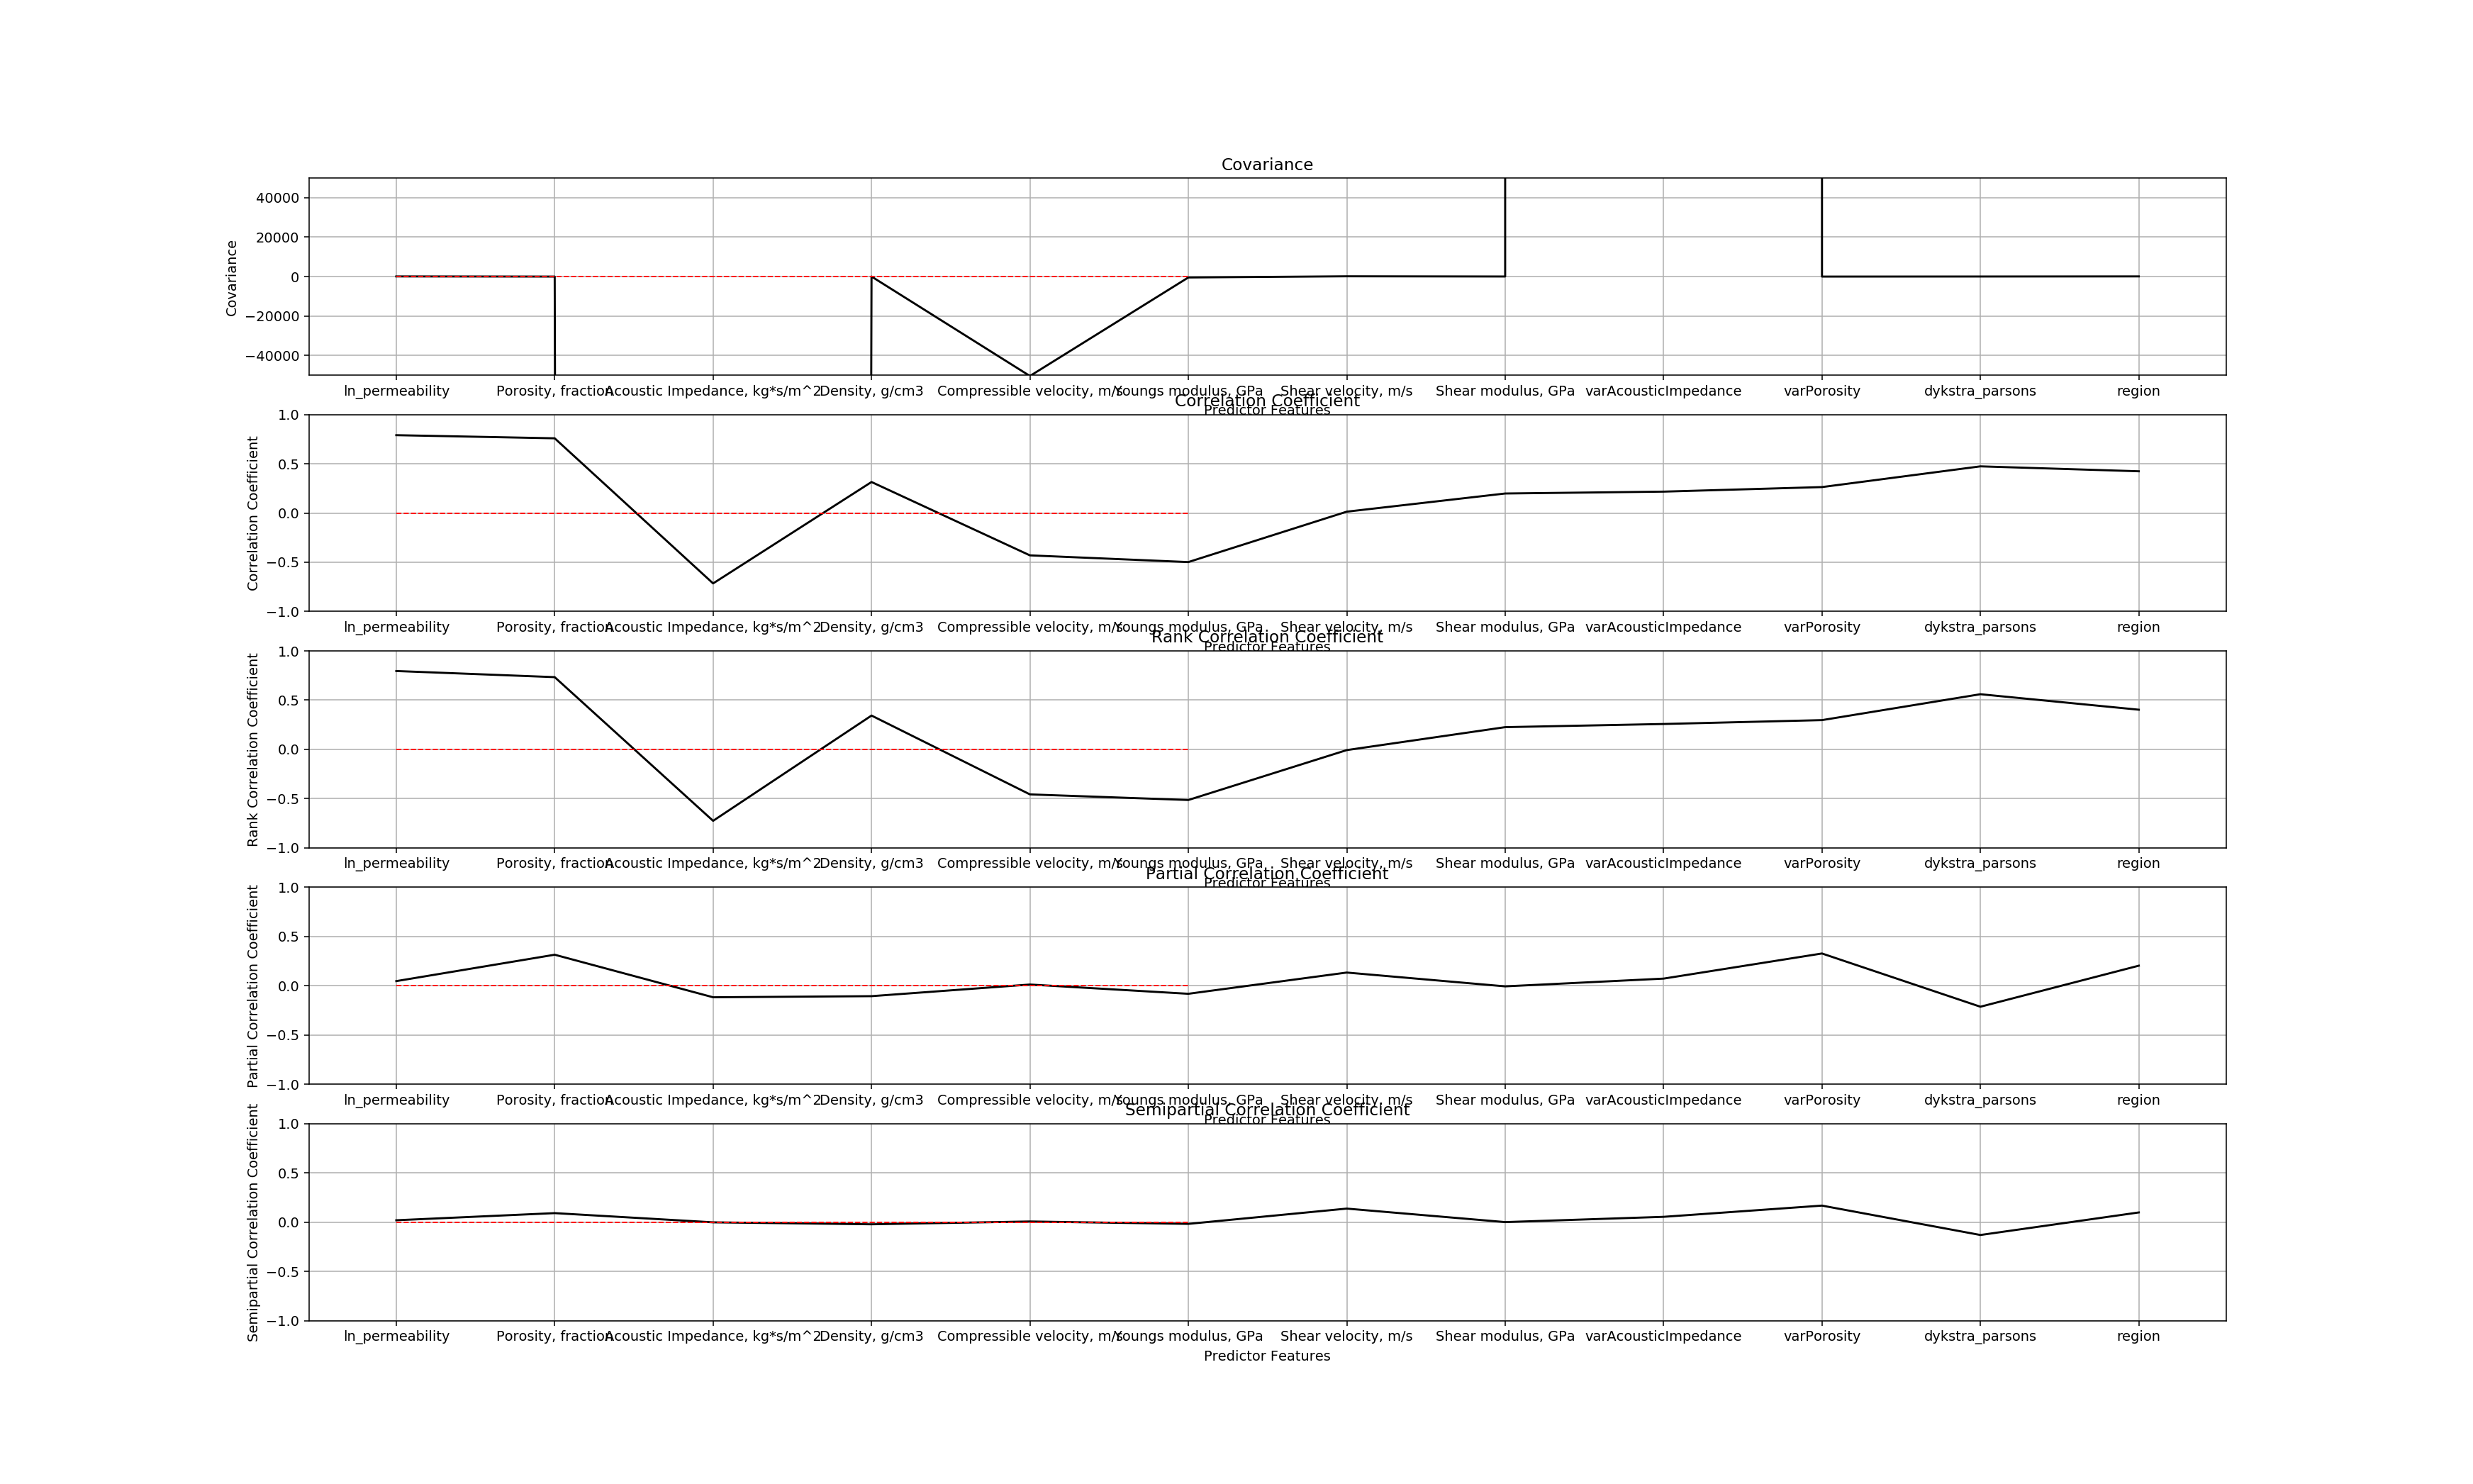

In [188]:
fig = plt.figure(figsize = [25,15])

features = df.columns.values[1:][:features-1]
plt.subplot(511)
plt.plot(features,covariance,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-50000,50000)
plt.grid(True)

plt.subplot(512)
plt.plot(features,correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(513)
plt.plot(features,rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(514)
plt.plot(features,partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(515)
plt.plot(features,semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

#plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=0.75, wspace=1, hspace=1)
plt.show()



In [191]:
rfe = RFE(LinearRegression(), 1,verbose=0)      # set up RFE linear regression model
df['const'] = np.ones(len(df))                  # let's add one's for the constant term
rfe = rfe.fit(df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,14]].values,np.ravel(df.iloc[:,[13]])) # recursive elimination
dfS = df.drop('const',axis = 1)                 # remove the ones
print(rfe.ranking_[0:12])                             # print the variable ranks

[ 4  2 11  5 10  8  9  7 12  1  3  6]


In [192]:
df.columns.values[1:13]

array(['ln_permeability', 'Porosity, fraction',
       'Acoustic Impedance, kg*s/m^2', 'Density, g/cm3',
       'Compressible velocity, m/s', 'Youngs modulus, GPa',
       'Shear velocity, m/s', 'Shear modulus, GPa',
       'varAcousticImpedance', 'varPorosity', 'dykstra_parsons', 'region'],
      dtype=object)